In [1]:
from pandas import read_csv
from datetime import datetime
import timeit
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [2]:
#Extracts data from file 'US Data.xlsx': the file contains information on Apple stock Open, close price, volume
#and 6 other fundamental data points about the stock. In addition, we have combined macro data points: S&P index,
#VIX volatility index and PPUT which is the put option price for S&P
data=pd.read_excel('US Data.xlsx')
data.head()

,Date,Open Price,Last Price,Financial Leverage,Volume,PE RATIO,Cash Flow Per Share,Price to Book Ratio,Dividend Per Share,SPX,VIX,PPUT
0,2014-02-03,71.8014,71.6471,1.7067,100620772,12.4425,3.6142,3.4514,0.4357,1741.89,21.44,593.43
1,2014-02-04,72.2643,72.6843,1.7067,94273543,12.6226,3.6142,3.5013,0.4357,1755.20,19.11,594.46
2,2014-02-05,72.3657,73.2271,1.7067,82322156,12.7169,3.6142,3.5275,0.4357,1751.64,19.95,594.10
3,2014-02-06,72.8657,73.2157,1.7067,64497223,12.7149,3.6142,3.5269,0.4357,1773.43,17.23,597.95
4,2014-02-07,74.4829,74.2400,1.7067,93638601,12.8928,3.6142,3.5763,0.4357,1797.02,15.29,603.01


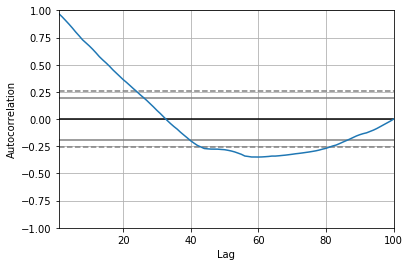

In [3]:
#testing number of days that's relevant
ts=data[['Date','Last Price']]
ts.set_index('Date', inplace=True)
autocorrelation_plot(ts.head(100))
pyplot.show()


In [4]:
#Intuitively, we know it is a non-stationary series, but let's have a ADfuller test anyway to verify.
#Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts['Last Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -0.910913
p-value: 0.784358


In [17]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    '''
 evaluate_models: eveluating ARIMA model with differeent p, d and q values.
 Input: dataset, p_values, d_values, q_values
 Output: print out MSE of each model with different combination of p, d and q values. Also in the end print out the best model result
    '''
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:           
            for q in q_values:       
                order = (p,d,q)
                print('order: ', order)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [16]:
def evaluate_arima_model(ts, order):
    '''
    evaluate_arima_model: evaluating a single arima model result
    input: ts(dataset), order(p,d,q)
    output: MSE of the model
    '''

    X = ts['Last Price'].values
    size = int(len(X) * 0.8)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    return error

In [7]:
# evaluate parameters
p_values = [1, 2,3]
d_values = [1, 2]
q_values = [2,3,4]

start = timeit.timeit()
evaluate_models(ts, p_values, d_values, q_values)
end= timeit.timeit()
print(end - start)


order:  (1, 1, 2)
order:  (1, 1, 3)
order:  (1, 1, 4)
order:  (1, 2, 2)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversio

order:  (1, 2, 3)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting he

order:  (1, 2, 4)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximu

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting he

ARIMA(1, 2, 4) MSE=12.827
ARIMA(1, 2, 4) MSE=12.827
order:  (2, 1, 2)
order:  (2, 1, 3)
order:  (2, 1, 4)
order:  (2, 2, 2)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: Conv

order:  (2, 2, 3)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


order:  (2, 2, 4)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihoo

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximu

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting he

ARIMA(2, 2, 4) MSE=12.981
order:  (3, 1, 2)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting he

ARIMA(3, 1, 2) MSE=13.013
order:  (3, 1, 3)
order:  (3, 1, 4)
order:  (3, 2, 2)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting he

ARIMA(3, 2, 2) MSE=12.776
ARIMA(3, 2, 2) MSE=12.776
order:  (3, 2, 3)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting he

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversio

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: I

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 2, 3) MSE=12.793
order:  (3, 2, 4)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: I

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: I

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversio

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversio

ARIMA(3, 2, 4) MSE=12.980
Best ARIMA(3, 2, 2) MSE=12.776
-0.004191714993794449


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting he

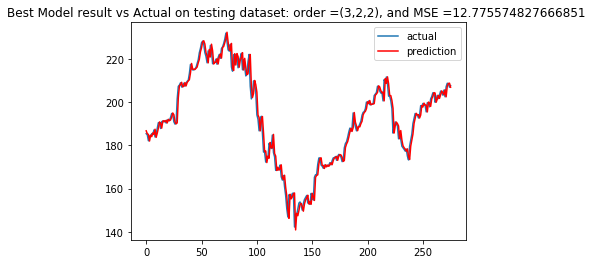

In [10]:
# plot best model from the above result: (3,2,2)

X = ts['Last Price'].values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,2,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
pyplot.plot(test, label = 'actual')
pyplot.plot(predictions, color='red', label = 'prediction')
pyplot.title('Best Model result vs Actual on testing dataset: order =(3,2,2), and MSE ={} '.format(error))
pyplot.legend()
pyplot.show()